<a href="https://colab.research.google.com/github/samiksha261/Tensorflow-File/blob/main/14_time_windows_forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
keras = tf.keras

In [2]:

def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end], series[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

    
def trend(time,slope=0):
    return slope*time
    
#seasonal Data
def seasonal_pattern(season_time):
    return np.where(season_time< 0.4,np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

# noise
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(4*365+1)
slope = 0.05
baseline = 10
amplitude = 40

In [4]:
series = baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
noise_level = 5
noise = white_noise(time,noise_level,seed=42)
series += noise

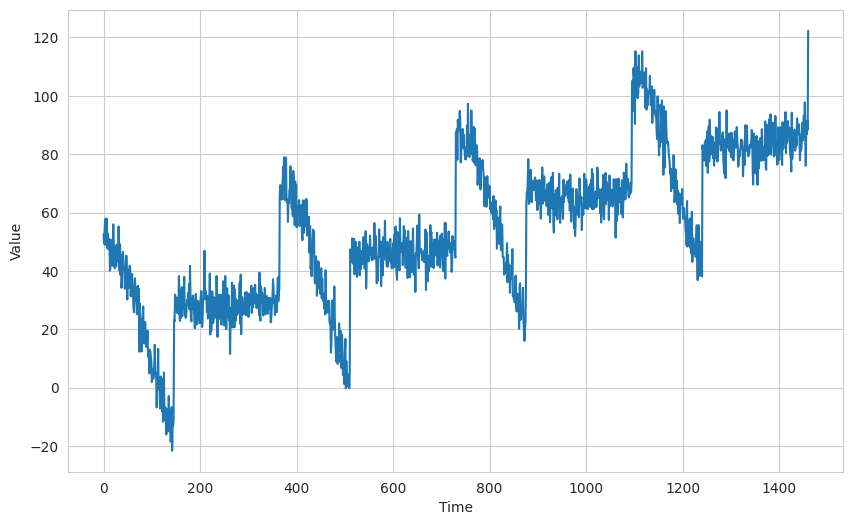

In [5]:
plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [6]:
def window_dataset(series,window_size,batch_size=32,shuffle_buffer=100):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window:(window[:-1],window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
split_time = 1000
time_train = time[:split_time]
X_train = series[:split_time]
time_valid = time[split_time:]
X_valid = series[split_time:]

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [9]:
train_set = window_dataset(X_train,window_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [10]:
valid_set = window_dataset(X_valid,window_size)

In [11]:
model = keras.models.Sequential([
    keras.layers.Dense(1,input_shape=[window_size])
])

In [12]:

optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [13]:
model.fit(train_set,epochs=10,validation_data=valid_set)

Epoch 1/10
31/31 [==============================] - 3s 59ms/step - loss: 57.8824 - mae: 58.3810 - val_loss: 13.2188 - val_mae: 13.7151
Epoch 2/10
31/31 [==============================] - 0s 10ms/step - loss: 14.3595 - mae: 14.8548 - val_loss: 8.5183 - val_mae: 9.0041
Epoch 3/10
31/31 [==============================] - 0s 10ms/step - loss: 7.7486 - mae: 8.2348 - val_loss: 7.3119 - val_mae: 7.7978
Epoch 4/10
31/31 [==============================] - 1s 15ms/step - loss: 7.2825 - mae: 7.7675 - val_loss: 7.1710 - val_mae: 7.6549
Epoch 5/10
31/31 [==============================] - 1s 21ms/step - loss: 7.1138 - mae: 7.5980 - val_loss: 7.0847 - val_mae: 7.5679
Epoch 6/10
31/31 [==============================] - 0s 11ms/step - loss: 7.0139 - mae: 7.4980 - val_loss: 7.0620 - val_mae: 7.5477
Epoch 7/10
31/31 [==============================] - 0s 11ms/step - loss: 6.8868 - mae: 7.3712 - val_loss: 6.8965 - val_mae: 7.3814
Epoch 8/10
31/31 [==============================] - 0s 14ms/step - loss: 6.79

In [14]:
# Tunning
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [15]:
train_set = window_dataset(X_train,window_size)

In [16]:
model = keras.models.Sequential([
    keras.layers.Dense(1,input_shape=[window_size])
])

In [17]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6*10**(epoch/30))

In [18]:
optimizer = keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9)

In [19]:
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [20]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 13ms/step - loss: 87.5058 - mae: 88.0053 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 12ms/step - loss: 71.7783 - mae: 72.2777 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 53.5047 - mae: 54.0039 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 33.9127 - mae: 34.4124 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 14.3882 - mae: 14.8824 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 8.5055 - mae: 8.9935 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 8.4901 - mae: 8.9793 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 8.4158 - mae: 8.9052 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 8.3676 - mae: 8.8543 - lr: 

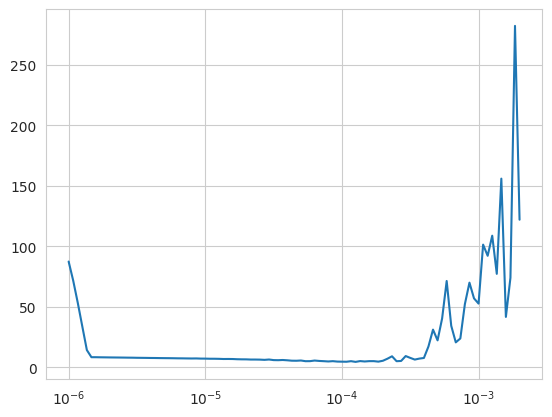

In [21]:
plt.semilogx(history.history['lr'],history.history['loss'])
#plt.axis(1e-6,1e-3,0,20)
plt.show()

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [23]:
train_set = window_dataset(X_train,window_size)
valid_set = window_dataset(X_valid,window_size)

In [24]:
model = keras.models.Sequential([
    keras.layers.Dense(1,input_shape=[window_size])
])

In [25]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [26]:
early_stooping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set,epochs=500,validation_data=valid_set,callbacks=[early_stooping])

Epoch 1/500
31/31 [==============================] - 2s 31ms/step - loss: 16.0225 - mae: 16.5143 - val_loss: 11.2835 - val_mae: 11.7738
Epoch 2/500
31/31 [==============================] - 1s 22ms/step - loss: 12.0405 - mae: 12.5303 - val_loss: 10.7141 - val_mae: 11.2027
Epoch 3/500
31/31 [==============================] - 1s 23ms/step - loss: 11.1888 - mae: 11.6777 - val_loss: 10.4015 - val_mae: 10.8922
Epoch 4/500
31/31 [==============================] - 0s 11ms/step - loss: 10.9327 - mae: 11.4211 - val_loss: 10.1999 - val_mae: 10.6901
Epoch 5/500
31/31 [==============================] - 0s 10ms/step - loss: 10.6865 - mae: 11.1726 - val_loss: 9.9756 - val_mae: 10.4624
Epoch 6/500
31/31 [==============================] - 0s 11ms/step - loss: 10.5523 - mae: 11.0400 - val_loss: 9.7965 - val_mae: 10.2848
Epoch 7/500
31/31 [==============================] - 0s 11ms/step - loss: 10.2833 - mae: 10.7721 - val_loss: 9.6240 - val_mae: 10.1127
Epoch 8/500
31/31 [==============================] 

In [27]:
def model_forcast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [28]:
lin_forecast = model_forcast(model,series[split_time-window_size:-1],window_size)[:,0]

15/15 [==============================] - 0s 7ms/step


In [29]:
lin_forecast

array([ 65.72563 ,  67.9909  ,  71.56647 ,  69.10103 ,  64.96731 ,
        67.73695 ,  67.194664,  68.0358  ,  68.96907 ,  68.68111 ,
        67.13901 ,  68.98731 ,  68.52234 ,  71.249   ,  67.372894,
        70.878174,  68.10183 ,  67.38856 ,  65.34785 ,  65.48098 ,
        65.446106,  66.0245  ,  65.39204 ,  66.34453 ,  68.7659  ,
        70.639595,  71.03665 ,  68.51226 ,  69.22579 ,  68.14172 ,
        67.39536 ,  64.71306 ,  61.622467,  64.6004  ,  65.417885,
        65.183876,  68.03871 ,  64.65791 ,  64.406075,  64.37886 ,
        66.417534,  70.43047 ,  67.57712 ,  68.562744,  67.216995,
        68.167114,  69.78962 ,  68.66633 ,  65.60469 ,  67.71947 ,
        69.14908 ,  70.27399 ,  66.75577 ,  66.8588  ,  69.00228 ,
        66.81414 ,  66.192955,  65.324135,  68.07184 ,  68.21171 ,
        66.13199 ,  69.42862 ,  63.995136,  65.44466 ,  64.13001 ,
        64.000404,  61.493813,  63.38228 ,  64.53047 ,  65.12875 ,
        66.216866,  66.413284,  68.389534,  67.8997  ,  65.509

In [30]:
lin_forecast.shape

(461,)

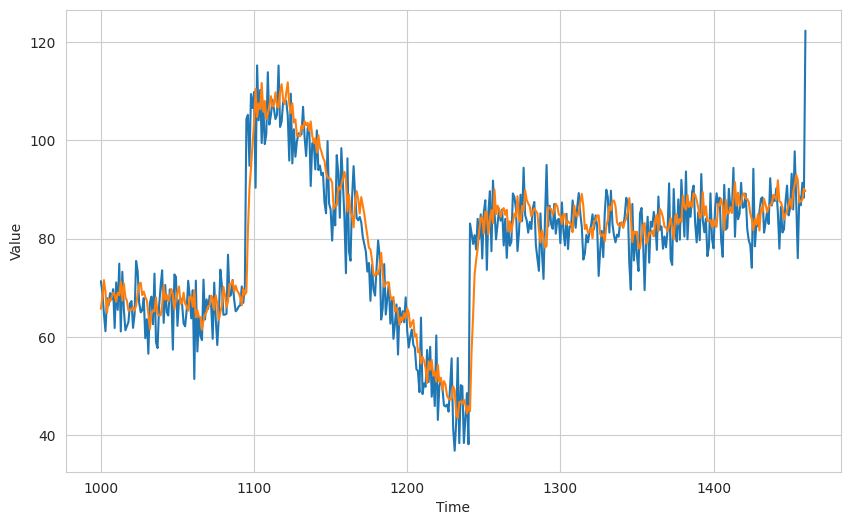

In [31]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,lin_forecast)

In [32]:
# Dense Model 
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30
train_set = window_dataset(X_train,window_size)

In [33]:
model = keras.models.Sequential([
    keras.layers.Dense(10,activation='relu',input_shape=[window_size]),
    keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(1)
])

In [34]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7*10**(epoch/20))

In [35]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 2s 14ms/step - loss: 63.0292 - mae: 63.5281 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 1s 14ms/step - loss: 61.0736 - mae: 61.5724 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 1s 15ms/step - loss: 58.7349 - mae: 59.2336 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 56.1339 - mae: 56.6326 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 53.2424 - mae: 53.7405 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 50.0768 - mae: 50.5756 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 46.6551 - mae: 47.1539 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 43.0188 - mae: 43.5182 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 39.2031 - mae: 39.7

(1e-07, 0.005, 0.0, 30.0)

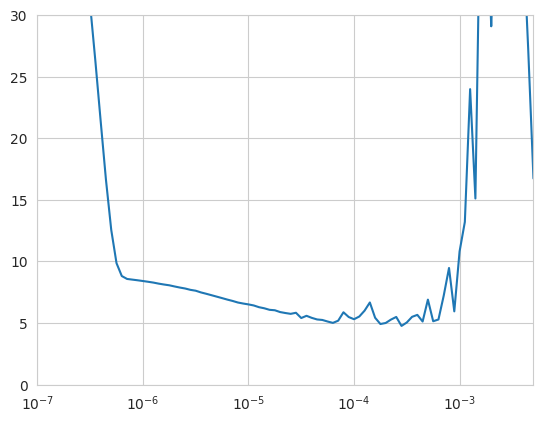

In [36]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-7,5e-3,0,30])


In [37]:
# tunning
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30
train_set = window_dataset(X_train,window_size)

In [38]:
model = keras.models.Sequential([
    keras.layers.Dense(10,activation='relu',input_shape=[window_size]),
    keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(1)
])

In [39]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [40]:
early_stooping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set,epochs=500,
         validation_data=valid_set,
         callbacks=[early_stooping])

Epoch 1/500
31/31 [==============================] - 2s 45ms/step - loss: 25.4318 - mae: 25.9289 - val_loss: 14.7194 - val_mae: 15.2172
Epoch 2/500
31/31 [==============================] - 0s 11ms/step - loss: 7.9535 - mae: 8.4375 - val_loss: 7.1884 - val_mae: 7.6715
Epoch 3/500
31/31 [==============================] - 0s 11ms/step - loss: 7.0261 - mae: 7.5102 - val_loss: 7.3221 - val_mae: 7.8093
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 6.7446 - mae: 7.2273 - val_loss: 6.6254 - val_mae: 7.1082
Epoch 5/500
31/31 [==============================] - 0s 10ms/step - loss: 6.6860 - mae: 7.1697 - val_loss: 6.3333 - val_mae: 6.8141
Epoch 6/500
31/31 [==============================] - 0s 10ms/step - loss: 6.6294 - mae: 7.1135 - val_loss: 6.2162 - val_mae: 6.6946
Epoch 7/500
31/31 [==============================] - 0s 8ms/step - loss: 6.4529 - mae: 6.9345 - val_loss: 6.1685 - val_mae: 6.6558
Epoch 8/500
31/31 [==============================] - 0s 10ms/step - loss: 

In [41]:
dense_forcast = model_forcast(model,
                             series[split_time-window_size:-1],window_size)[:,0]

15/15 [==============================] - 2s 7ms/step


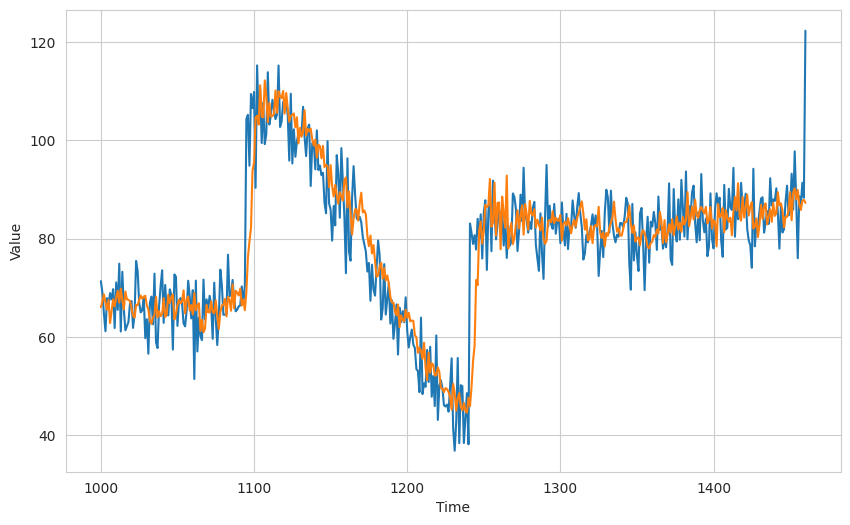

In [42]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,dense_forcast)

In [43]:
keras.metrics.mean_absolute_error(X_valid,dense_forcast).numpy()

5.2046776